In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import pickle as pkl
import math
import glob
import os

from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.text import Text
from adjustText import adjust_text
from matplotlib.patches import Ellipse
from matplotlib.collections import PathCollection

import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-2]+['eval','cleaned','']))
from params_opt_maps import *

In [2]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_names=path_data+'names_parsed/'
path_fig=path_data+'figures/'
path_tab=path_data+'tables/'

In [3]:
# Names
model_map={**pkl.load(open(path_names+'models.pkl','rb')),
           **pkl.load(open(path_names+'models_additional.pkl','rb'))}
param_map={**pkl.load(open(path_names+'params.pkl','rb')),
          **pkl.load(open(path_names+'params_additional.pkl','rb'))}
metric_map=pkl.load(open(path_names+'metrics.pkl','rb'))
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
metric_meaning_map=pkl.load(open(path_names+'metric_meanings.pkl','rb'))
metric_map_rev=dict(zip(metric_map.values(),metric_map.keys()))
dataset_map_rev=dict(zip(dataset_map.values(),dataset_map.keys()))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))
params_opt_map={**pkl.load(open(path_names+'params_opt_model.pkl','rb')),
               **pkl.load(open(path_names+'params_opt_model_additional.pkl','rb'))}
param_opt_vals=pkl.load(open(path_names+'optimized_parameter_values.pkl','rb'))+\
                pkl.load(open(path_names+'optimized_parameter_values_additional.pkl','rb'))
prior_init_map=pkl.load(open(path_names+'prior_init.pkl','rb'))
cell_type_map=pkl.load(open(path_names+'cell_types.pkl','rb'))

# cmap
model_cmap=pkl.load(open(path_names+'model_cmap.pkl','rb'))
obs_col_cmap=pkl.load(open(path_names+'obs_col_cmap.pkl','rb'))
metric_background_cmap=pkl.load(open(path_names+'metric_background_cmap.pkl','rb'))

### Metric scores for VAMP & GMM with different number of trainable/fixed prior components

#### Load data

In [4]:
# Load data and keep relevant runs
ress=[]
for dataset,dataset_name in dataset_map.items():
    print(dataset_name)
    path_integration=f'{path_data}eval/{dataset}/integration/'
    res=[]
    for run in glob.glob(path_integration+'*/'):
        if os.path.exists(run+'args.pkl') and \
            os.path.exists(run+'scib_metrics.pkl'):
            args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
            if args.params_opt in ['vamp_eval', 'vamp_eval_fixed', 'gmm_eval',
                                  'gmm_eval_fixed', 'gmm_eval_ri']:
                metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
                data=pd.concat([args,metrics])
                name=run.split('/')[-2]
                data.name=name
                res.append(data)
    res=pd.concat(res,axis=1).T

    # Parse res table

    # Parse params
    res['params_opt']=res.params_opt.replace(params_opt_correct_map)
    res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
    res['param_opt_val']=res.apply(
        lambda x: (x[x['param_opt_col']] if not isinstance(x[x['param_opt_col']],dict)
                  else x[x['param_opt_col']]['weight_end']) 
                  if x['param_opt_col'] is not None else 0,axis=1)
    # param opt val for plotting - converted to str categ below
    res['param_opt_val_str']=res.apply(
        lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else np.nan,axis=1)
    
    res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

    # Keep relevant params and name model
    params_opt_vals=set(params_opt_map.keys())
    res_sub=res.query('params_opt in @params_opt_vals').copy()
    res_sub['model']=res_sub.params_opt.replace(params_opt_map).astype(str)   
    # Models present in data but have no params opt
    nonopt_models=list(
        (set(params_opt_map.values()) & set(res_sub['model'].unique()))-set(
        [model for models,params_vals in param_opt_vals for model in models]))
    # Query: model not opt OR model belongs to one of the models that have opt params
    # and if given param is opt then it is within list of param values
    res_query=[f'model in {nonopt_models}']
    # Models with opt params
    for models,params_vals in param_opt_vals:
        res_query_sub=[]
        # Param value in vals if param was optimised
        for param,vals in params_vals:
            # For param check if it was opt in data as else there will be no col for it
            if param in res_sub.columns:
                res_query_sub.append(f'({param} in {vals} & "{param}"==param_opt_col)')
        # Only add to query models for which any param was opt
        if len(res_query_sub)>0:
            res_query_sub='(('+' | '.join(res_query_sub)+f') & model in {models})'
            res_query.append(res_query_sub)
    res_query=' | '.join(res_query)
    #print(res_query)
    res_sub=res_sub.query(res_query).copy()

    # Add pretty model names
    res_sub['model_parsed']=res_sub['model'].map(model_map)
    res_sub['model_parsed']=pd.Categorical(
        values=res_sub['model_parsed'],
        categories=[c for c in model_map.values() if c in res_sub['model_parsed'].unique()], 
        ordered=True)
    # Add prety param names
    res_sub['param_parsed']=pd.Categorical(
        values=res_sub['param_opt_col'].map(param_map),
        categories=param_map.values(), ordered=True)
    
    display(res_sub.groupby(['model_parsed','param_parsed'],observed=True).size())
    
    # Store
    res_sub['dataset_parsed']=dataset_name
    ress.append(res_sub)
    
ress=pd.concat(ress)
ress['dataset_parsed']=pd.Categorical(
    values=ress['dataset_parsed'],
    categories=list(dataset_map.values()), ordered=True)

# plotting param vals
ress['param_opt_val_str']=pd.Categorical(
    values=ress['param_opt_val_str'].fillna('none').astype(str),
    categories=[str(i) for i in 
                sorted([i for i in ress['param_opt_val_str'].unique() if not np.isnan(i)])
               ]+['none'],
    ordered=True)

Mouse-Human


model_parsed  param_parsed
VAMP          N priors        18
VAMP - FP     N priors        18
GMM           N priors        18
GMM - RPI     N priors        18
GMM - FP      N priors        18
dtype: int64

Organoid-Tissue


model_parsed  param_parsed
VAMP          N priors        18
VAMP - FP     N priors        18
GMM           N priors        18
GMM - RPI     N priors        18
GMM - FP      N priors        18
dtype: int64

Cell-Nuclei


model_parsed  param_parsed
VAMP          N priors        18
VAMP - FP     N priors        18
GMM           N priors        18
GMM - RPI     N priors        18
GMM - FP      N priors        18
dtype: int64

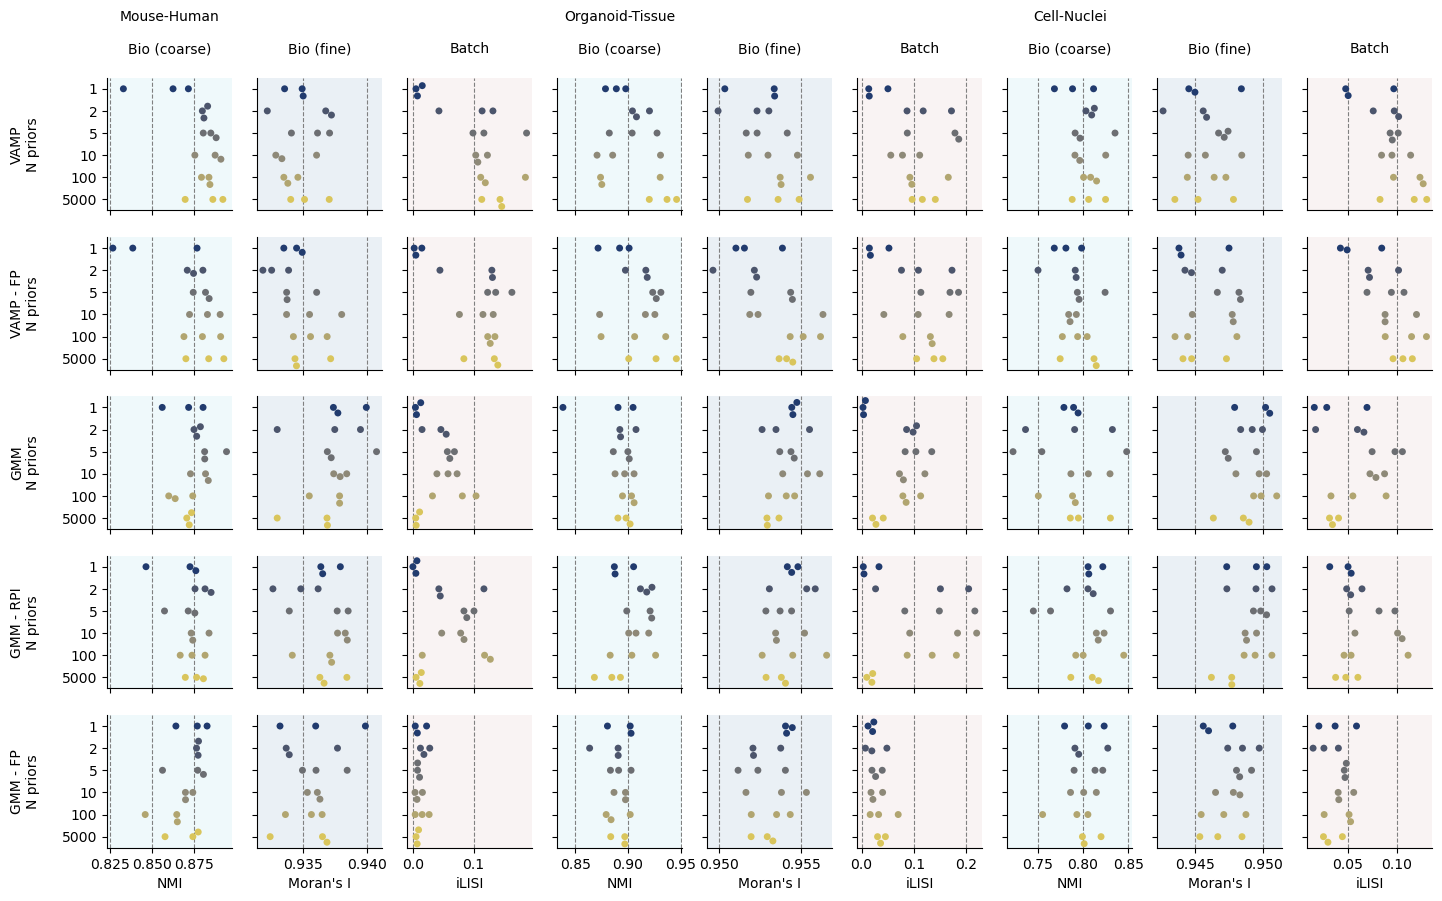

In [6]:
# Plot
params=ress.groupby(['model_parsed','param_parsed'],observed=True,sort=True
            ).size().index.to_frame().reset_index(drop=True)
nrow=params.shape[0]
n_metrics=len(metric_map)
ncol=ress['dataset_parsed'].nunique()*n_metrics
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*1.9,nrow*2),sharex='col',sharey='row')
for icol_ds, (dataset_name,res_ds) in enumerate(ress.groupby('dataset_parsed')):
    
    # Max row for ds
    models_parsed_ds=set(res_ds.model_parsed)
    params_parsed_ds=set(res_ds.param_parsed)
    irow_max_ds=max([irow for irow,(model_parsed,param_parsed) in params.iterrows() if 
     model_parsed in models_parsed_ds and 
     param_parsed in params_parsed_ds ])
    
    # Plot model + optimized param combination
    for icol_metric,(metric,metric_name) in enumerate(metric_map.items()):
        icol=icol_ds*n_metrics+icol_metric
        for irow,(_,param_data) in enumerate(params.iterrows()):
            ax=axs[irow,icol]
            res_sub=res_ds.query(
                f'model_parsed=="{param_data.model_parsed}" & '+\
                f'param_parsed=="{param_data.param_parsed}" ')
            if res_sub.shape[0]>0:
                res_sub=res_sub.copy()
                res_sub['param_opt_val_str']=\
                    res_sub['param_opt_val_str'].cat.remove_unused_categories()
                sb.swarmplot(x=metric,y='param_opt_val_str',data=res_sub,ax=ax, 
                            hue='param_opt_val_str',palette='cividis')
                
                # make pretty
                ax.set(facecolor = metric_background_cmap[metric])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.grid(axis='x', linestyle='--', color='gray')
                ax.get_legend().remove()
                if irow!=irow_max_ds:
                    ax.set_xlabel('')
                else:
                    # Add xaxis
                    # Must turn label to visible as sb will set it off if sharex
                    # Must reset ticks as will be of due to sharex
                    ax.set_xlabel(metric_name,visible=True)
                    #ax.xaxis.set_label_position('bottom') 
                    ax.xaxis.set_ticks_position('bottom')
                if irow==0:
                    title=''
                    if icol%3==0:
                        title=title+dataset_name+'\n\n'
                    ax.set_title(title+metric_meaning_map[metric]+'\n',fontsize=10)
                if icol==0:
                    ax.set_ylabel(
                        param_data.model_parsed+'\n'+\
                        param_data.param_parsed+'\n')
                else:
                    ax.set_ylabel('')
            else:
                ax.remove()
            

plt.subplots_adjust(wspace=0.2,hspace=0.2)
fig.set(facecolor = (0,0,0,0))
# Turn off tight layout as it messes up spacing if adding xlabels on intermediate plots
#fig.tight_layout()

# Save
plt.savefig(path_fig+'performance_vamp-score_all-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'performance_vamp-score_all-swarm.png',
            dpi=300,bbox_inches='tight')

Statistical significance of metric differences when increasing number of priors. Comparisons are done between successive number of tested prior components per dataset and model. Pvalue is adjusted per model and datasets.

In [ ]:
# Compute significance
pvals=[]
for (dataset_name,model_name), res_sub in ress.groupby(['dataset_parsed','model_parsed']):
    priors=[c for c in res_sub['param_opt_val_str'].cat.categories if c!='none']
    for metric,metric_name in metric_map.items():
        pvals_sub=[]
        for n in range(len(priors)-1):
            p1=priors[n]
            p2=priors[n+1]
            t,p=ttest_ind(
                res_sub.query('param_opt_val_str==@p2')[metric].astype(float), 
                res_sub.query('param_opt_val_str==@p1')[metric].astype(float), 
                equal_var=False, alternative='two-sided')
            pvals_sub.append(dict(
                dataset=dataset_name,metric=metric_name,model=model_name,
                p=p,t=t,
                n_priors_base=p1,n_priors_higher=p2))
        pvals_sub=pd.DataFrame(pvals_sub)
        padj_method='bonferroni'
        pvals_sub['padj_'+padj_method]=multipletests(pvals_sub['p'].values, method=padj_method)[1]
        pvals.append(pvals_sub)
pvals=pd.concat(pvals)
pvals.to_csv(path_tab+'performance_vamp-score_all-successive_significance.tsv',sep='\t',index=None)

#### Simplified summary of selected models on pancreas data

In [5]:
# Subset to models and datasets
models=['vamp','vamp_fixed','gmm']
dataset_names=[dataset_map['pancreas_conditions_MIA_HPAP2']]
ress_sub=ress.query('model in @models & dataset_parsed in @dataset_names')

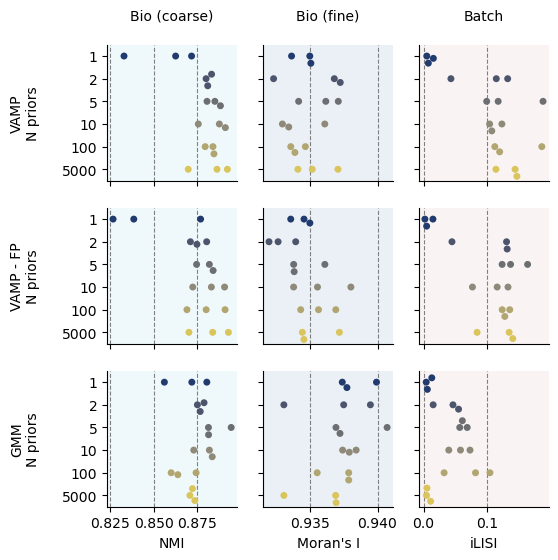

In [8]:
params=ress_sub.groupby(['model_parsed','param_parsed'],observed=True,sort=True
            ).size().index.to_frame().reset_index(drop=True)
nrow=params.shape[0]
n_metrics=len(metric_map)
ncol=ress_sub['dataset_parsed'].nunique()*n_metrics
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*1.9,nrow*2),sharex='col',sharey='row')
for icol_ds, (dataset_name,res_ds) in enumerate(ress_sub.groupby('dataset_parsed',observed=True)):
    
    # Max row for ds
    models_parsed_ds=set(res_ds.model_parsed)
    params_parsed_ds=set(res_ds.param_parsed)
    irow_max_ds=max([irow for irow,(model_parsed,param_parsed) in params.iterrows() if 
     model_parsed in models_parsed_ds and 
     param_parsed in params_parsed_ds ])
    
    for icol_metric,(metric,metric_name) in enumerate(metric_map.items()):
        icol=icol_ds*n_metrics+icol_metric
        for irow,(_,param_data) in enumerate(params.iterrows()):
            ax=axs[irow,icol]
            res_sub=res_ds.query(
                f'model_parsed=="{param_data.model_parsed}" & '+\
                f'param_parsed=="{param_data.param_parsed}" ')
            if res_sub.shape[0]>0:
                res_sub=res_sub.copy()
                res_sub['param_opt_val_str']=\
                    res_sub['param_opt_val_str'].cat.remove_unused_categories()
                sb.swarmplot(x=metric,y='param_opt_val_str',data=res_sub,ax=ax, 
                            hue='param_opt_val_str',palette='cividis')
                ax.set(facecolor = metric_background_cmap[metric])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.grid(axis='x', linestyle='--', color='gray')
                ax.get_legend().remove()
                if irow!=irow_max_ds:
                    ax.set_xlabel('')
                else:
                    # Add xaxis
                    # Must turn label to visible as sb will set it off if sharex
                    # Must reset ticks as will be of due to sharex
                    ax.set_xlabel(metric_name,visible=True)
                    #ax.xaxis.set_label_position('bottom') 
                    ax.xaxis.set_ticks_position('bottom')
                if irow==0:
                    title=''
                    #if icol%3==0:
                    #    title=title+dataset_name+'\n\n'
                    ax.set_title(title+metric_meaning_map[metric]+'\n',fontsize=10)
                if icol==0:
                    ax.set_ylabel(
                        param_data.model_parsed+'\n'+\
                        param_data.param_parsed+'\n')
                else:
                    ax.set_ylabel('')
            else:
                ax.remove()
            

plt.subplots_adjust(wspace=0.2,hspace=0.2)
fig.set(facecolor = (0,0,0,0))
# Turn off tight layout as it messes up spacing if adding xlabels on intermediate plots
#fig.tight_layout()

plt.savefig(path_fig+'performance_vamp-score_vampSub_pancreas-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'performance_vamp-score_vampSub_pancreas-swarm.png',
            dpi=300,bbox_inches='tight')

#### 2D summary

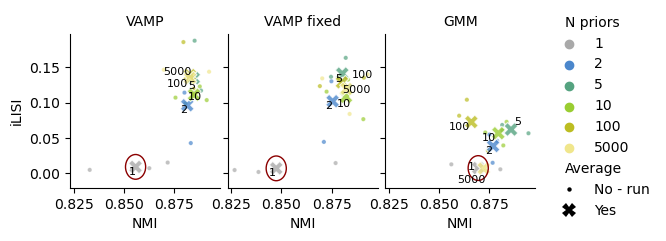

In [102]:
# Plot

res_plot=ress_sub.copy()
param_opt_val_col=param_map['n_prior_components']
# Make categorical for coloring
res_plot[param_opt_val_col]=pd.Categorical(res_plot['param_opt_val'],sorted(res_plot['param_opt_val'].unique()),ordered=True)
res_plot['model_parsed']=res_plot['model_parsed'].cat.remove_unused_categories()
# avg DF
res_plot_me=res_plot.groupby(['model_parsed',param_opt_val_col]
                            )[['nmi_opt','ilisi_system']].mean().reset_index()
# Shuffle points as else some param_opt_vals are on top
res_plot=res_plot.loc[np.random.RandomState(seed=0).permutation(res_plot.index),:]

# Plot
s_run=10
s_avg=100
marker_avg='X'
colors=['darkgray', '#4b87cc', '#55a380', 'yellowgreen', 'tab:olive', 'khaki']
ncol=res_plot.model_parsed.nunique()
fig,axs=plt.subplots(1,ncol,figsize=(2*ncol,2),sharey=True,sharex=True)
# Assert that all models have same category values (as not checked for legend below)
assert res_plot.groupby('model_parsed')['param_opt_val'].apply(
    lambda x: ','.join(sorted(set(x.astype(str))))).nunique()==1
# Plot per model
for idx,model_name in enumerate(res_plot['model_parsed'].cat.categories):
    ax=axs[idx]
    sb.scatterplot(y='ilisi_system',x='nmi_opt',hue=param_opt_val_col,
                   s=s_run,palette=colors,lw=0,alpha=0.7,
                   data=res_plot.query('model_parsed==@model_name'),ax=ax)
    sb.scatterplot(y='ilisi_system',x='nmi_opt',hue=param_opt_val_col,
                   s=s_avg,palette=colors,marker=marker_avg,
                   data=res_plot_me.query('model_parsed==@model_name'),ax=ax,
                   alpha=0.8, lw=0,legend=False)
    
    # Mark obe prior case
    circle = Ellipse(res_plot_me.query(
            'model_parsed==@model_name & `N priors`==1')[['nmi_opt','ilisi_system']].values.ravel(),
        # The width/height ratio should be computed after setting axes range, but this should do for now
        0.01,0.01*(res_plot_me['ilisi_system'].max()-res_plot_me['ilisi_system'].min())/(
            res_plot_me['nmi_opt'].max()-res_plot_me['nmi_opt'].min()),
        linewidth=1, fill=False,color='#8b0000')
    ax.add_patch(circle)
    
    # Annotate means with N priors
    texts=[ax.text(data['nmi_opt'], data['ilisi_system'], data[param_opt_val_col], 
                   color='k', fontsize=8) 
           for row,data in res_plot_me.query('model_parsed==@model_name').iterrows()]
    adjust_text(texts,min_arrow_len=1e6,
            arrowprops=dict(arrowstyle="->",  color='k',  lw=0.5),  ax=ax)
    
    # Make pretty
    ax.set_title(model_name.replace ('- FP','fixed') ,fontsize=10)
    if idx==0:
        ax.set_ylabel(metric_map['ilisi_system'])
    ax.set_xlabel(metric_map['nmi_opt'])
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx!=(ncol-1):
        ax.get_legend().remove()
    else:
        handles,labels=ax.get_legend_handles_labels()
        handles=[Line2D([0], [0],  markersize=0, lw=0, markeredgewidth=0)]+handles+\
                [Line2D([0], [0],  markersize=0, lw=0, markeredgewidth=0),
                 Line2D([0], [0], marker='o', color='k', markersize=s_run**0.5, 
                               lw=0,markeredgewidth=0),
                 Line2D([0], [0], marker=marker_avg, color='k', markersize=s_avg**0.5, 
                               lw=0,markeredgewidth=0)]
        labels=[param_opt_val_col]+labels+['Average','No - run','Yes']
        ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05,1.2),frameon=False)
        for text in ax.get_legend().get_texts():
            if text.get_text() in [param_opt_val_col,'Average']:
                text.set_position((text.get_position()[0] - 29,text.get_position()[1]))
fig.subplots_adjust(wspace=0.05)
_=fig.set(facecolor = (0,0,0,0))

# Save
plt.savefig(path_fig+'performance_vamp-score_vampSub_pancreas_2d-scatter.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'performance_vamp-score_vampSub_pancreas_2d-scatter.png',
            dpi=300,bbox_inches='tight')

### Effect of initialisation

#### Load data

In [156]:
# Load data and keep relevant runs
ress=[]
dataset='pancreas_conditions_MIA_HPAP2'
dataset_names=[dataset_map[dataset]]
path_integration=f'{path_data}eval/{dataset}/integration/'
res=[]
for run in glob.glob(path_integration+'*/'):
    if os.path.exists(run+'args.pkl') and \
        os.path.exists(run+'scib_metrics.pkl'):
        args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
        if args.params_opt in ['vamp_eval']:
            metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
            data=pd.concat([args,metrics])
            name=run.split('/')[-2]
            data.name=name
            res.append(data)
path_integration=f'{path_data}eval/{dataset}_priorLoc/integration/'
for run in glob.glob(path_integration+'*/'):
    if os.path.exists(run+'args.pkl') and \
        os.path.exists(run+'scib_metrics.pkl'):
        args=pd.Series(vars(pkl.load(open(run+'args.pkl','rb'))))
        metrics=pd.Series(pkl.load(open(run+'scib_metrics.pkl','rb')))
        data=pd.concat([args,metrics])
        name=run.split('/')[-2]
        data.name=name
        res.append(data)
res=pd.concat(res,axis=1).T

# Parse res table

# Parse params
res['params_opt']=res.params_opt.replace(params_opt_correct_map)
res['param_opt_col']=res.params_opt.replace(param_opt_col_map)
res['param_opt_val']=res.apply(
    lambda x: (x[x['param_opt_col']] if not isinstance(x[x['param_opt_col']],dict)
              else x[x['param_opt_col']]['weight_end']) 
              if x['param_opt_col'] is not None else 0,axis=1)
# param opt val for plotting - converted to str categ below
res['param_opt_val_str']=res.apply(
    lambda x: x[x['param_opt_col']] if x['param_opt_col'] is not None else np.nan,axis=1)

res['params_opt']=pd.Categorical(res['params_opt'],sorted(res['params_opt'].unique()), True)

# Keep relevant params and name model
params_opt_vals=set(params_opt_map.keys())
res_sub=res.query('params_opt in @params_opt_vals').copy()
res_sub['model']=res_sub.params_opt.replace(params_opt_map).astype(str)   
# Models present in data but have no params opt
nonopt_models=list(
    (set(params_opt_map.values()) & set(res_sub['model'].unique()))-set(
    [model for models,params_vals in param_opt_vals for model in models]))
# Query: model not opt OR model belongs to one of the models that have opt params
# and if given param is opt then it is within list of param values
res_query=[f'model in {nonopt_models}']
# Models with opt params
for models,params_vals in param_opt_vals:
    res_query_sub=[]
    # Param value in vals if param was optimised
    for param,vals in params_vals:
        # For param check if it was opt in data as else there will be no col for it
        if param in res_sub.columns:
            res_query_sub.append(f'({param} in {vals} & "{param}"==param_opt_col)')
    # Only add to query models for which any param was opt
    if len(res_query_sub)>0:
        res_query_sub='(('+' | '.join(res_query_sub)+f') & model in {models})'
        res_query.append(res_query_sub)
res_query=' | '.join(res_query)
#print(res_query)
res_sub=res_sub.query(res_query).copy()

# Add pretty model names
res_sub['model_parsed']=res_sub['model'].map(model_map)
res_sub['model_parsed']=pd.Categorical(
    values=res_sub['model_parsed'],
    categories=[c for c in model_map.values() if c in res_sub['model_parsed'].unique()], 
    ordered=True)
# Add prety param names
res_sub['param_parsed']=pd.Categorical(
    values=res_sub['param_opt_col'].map(param_map),
    categories=param_map.values(), ordered=True)

display(res_sub.groupby(['model_parsed','param_parsed'],observed=True).size())

# Store
res_sub['dataset_parsed']=dataset_name
ress.append(res_sub)
    
ress=pd.concat(ress)
ress['dataset_parsed']=pd.Categorical(
    values=ress['dataset_parsed'],
    categories=list(dataset_map.values()), ordered=True)

# Categories for prior component initialisation
categs=[]
idx=ress.query('param_opt_col=="prior_components_group"').index
ress.loc[idx,'param_opt_val_str']=ress.loc[idx,'param_opt_val_str'].map({
    **cell_type_map[dataset],**prior_init_map["prior_components_group"]})
categs.extend(prior_init_map["prior_components_group"].values()) 
categs.extend(cell_type_map[dataset].values())
idx=ress.query('param_opt_col=="prior_components_system"').index
ress.loc[idx,'param_opt_val_str']=ress.loc[idx,'param_opt_val_str'].astype(str).map({
    **system_map[dataset],**prior_init_map["prior_components_system"]})
categs.extend(prior_init_map["prior_components_system"].values()) 
categs.extend(system_map[dataset].values())    
categs.extend(sorted([i for i in ress.query(
    'param_opt_col!="prior_components_system" & param_opt_col!="prior_components_group"'
          )['param_opt_val_str'].unique() if  not np.isnan(i)]))
categs=[str(i) for i in dict.fromkeys(categs).keys()]+['none']
# plotting param vals
ress['param_opt_val_str']=pd.Categorical(
    values=ress['param_opt_val_str'].fillna('none').astype(str),
    categories=categs,
    ordered=True)

model_parsed  param_parsed         
VAMP          N priors                 18
              Prior init. cell type    18
              Prior init. system        9
dtype: int64

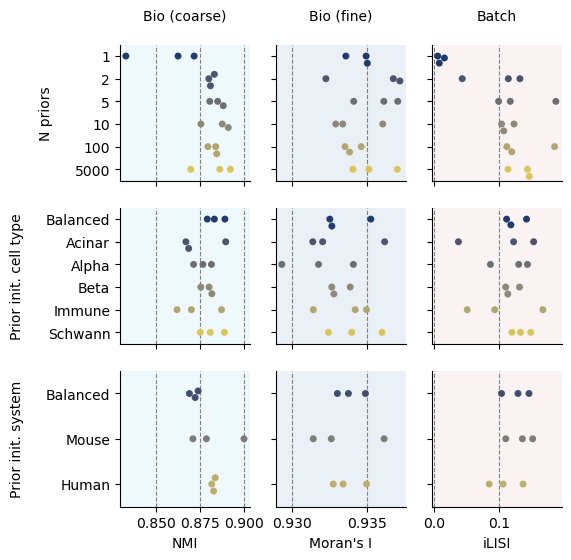

In [158]:
# Plot

params=ress.groupby(['model_parsed','param_parsed'],observed=True,sort=True
            ).size().index.to_frame().reset_index(drop=True)
nrow=params.shape[0]
n_metrics=len(metric_map)
ncol=ress['dataset_parsed'].nunique()*n_metrics
fig,axs=plt.subplots(nrow,ncol,figsize=(ncol*1.9,nrow*2),sharex='col',sharey='row')
for icol_ds, (dataset_name,res_ds) in enumerate(ress.groupby('dataset_parsed',observed=True)):
    
    # Max row for ds
    models_parsed_ds=set(res_ds.model_parsed)
    params_parsed_ds=set(res_ds.param_parsed)
    irow_max_ds=max([irow for irow,(model_parsed,param_parsed) in params.iterrows() if 
     model_parsed in models_parsed_ds and 
     param_parsed in params_parsed_ds ])
    
    # plot metrics for every optimised param
    for icol_metric,(metric,metric_name) in enumerate(metric_map.items()):
        icol=icol_ds*n_metrics+icol_metric
        for irow,(_,param_data) in enumerate(params.iterrows()):
            ax=axs[irow,icol]
            res_sub=res_ds.query(
                f'model_parsed=="{param_data.model_parsed}" & '+\
                f'param_parsed=="{param_data.param_parsed}" ')
            if res_sub.shape[0]>0:
                res_sub=res_sub.copy()
                res_sub['param_opt_val_str']=\
                    res_sub['param_opt_val_str'].cat.remove_unused_categories()
                sb.swarmplot(x=metric,y='param_opt_val_str',data=res_sub,ax=ax, 
                            hue='param_opt_val_str',palette='cividis')
                
                # make pretty
                ax.set(facecolor = metric_background_cmap[metric])
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.grid(axis='x', linestyle='--', color='gray')
                ax.get_legend().remove()
                if irow!=irow_max_ds:
                    ax.set_xlabel('')
                else:
                    # Add xaxis
                    # Must turn label to visible as sb will set it off if sharex
                    # Must reset ticks as will be of due to sharex
                    ax.set_xlabel(metric_name,visible=True)
                    ax.xaxis.set_ticks_position('bottom')
                if irow==0:
                    title=''
                    ax.set_title(title+metric_meaning_map[metric]+'\n',fontsize=10)
                if icol==0:
                    ax.set_ylabel(
                        param_data.param_parsed+'\n')
                else:
                    ax.set_ylabel('')
            else:
                ax.remove()
            

plt.subplots_adjust(wspace=0.2,hspace=0.2)
fig.set(facecolor = (0,0,0,0))
# Turn off tight layout as it messes up spacing if adding xlabels on intermediate plots
#fig.tight_layout()

# Save
plt.savefig(path_fig+'performance_vamp-score_init_pancreas-swarm.pdf',
            dpi=300,bbox_inches='tight')
plt.savefig(path_fig+'performance_vamp-score_init_pancreas-swarm.png',
            dpi=300,bbox_inches='tight')